In [1]:
!pip uninstall -y dask
!pip install dask==2024.8.0
!pip install -q datasets==2.21.0 jiwer evaluate

Found existing installation: dask 2024.12.1
Uninstalling dask-2024.12.1:
  Successfully uninstalled dask-2024.12.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.0 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-expr 1.1.21 requires dask==2024.12.1, but you have dask 2024.8.0 which is incompatible.
distributed 2024.12.1 requires dask==2024.12.1, but you have dask 2024.8.0 which is incompatible.
rapids-dask-dependency 25.2.0 requires dask==2024.12.1, but you have dask 2024.8.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 11.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━

In [2]:
!pip install transformers==4.45.2 sentence-transformers==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 89.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 3.3.1
    Uninstalling sentence-transformers-3.3.1:
      Successfully uninstalled sentence-transformers-3.3.1


In [3]:
import os
import json
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from transformers import default_data_collator
from transformers import ViTFeatureExtractor, RobertaTokenizer, XLMRobertaTokenizer, TrOCRProcessor, BertTokenizer
from transformers import VisionEncoderDecoderModel
from transformers import TrOCRProcessor
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

In [4]:
os.environ["WANDB_PROJECT"] = "trocr-handwriting"

In [5]:
def load_dataset(json_path):
    # Load the dataset
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # More thorough filtering
    temp = []
    skipped_count = 0
    for d in data:
        # Clean the text thoroughly
        text = d['text'].strip()
        
        # Skip invalid samples
        if not text or text.isspace() or len(text) == 0:
            skipped_count += 1
            print(f"Skipping sample {d['file']} due to invalid text: '{text}'")
            continue
            
        # Skip specific problematic files if needed
        if d['file'] == '100_8_15_8':
            skipped_count += 1
            print(f"Skipping sample {d['file']} as it is explicitly excluded")
            continue
            
        # Add valid samples to the list
        temp.append({
            'file': d['file'],
            'text': text  # Store the cleaned text
        })
    
    # Create and validate DataFrame
    df = pd.DataFrame(temp)
    
    print(f"Original dataset size: {len(data)}")
    print(f"Filtered dataset size: {len(df)}")
    print(f"Skipped {skipped_count} samples")
    
    # Final validation
    assert not df['text'].isna().any(), "Found NaN values in text column"
    assert not (df['text'].str.len() == 0).any(), "Found empty strings after filtering"
    
    return df

df = load_dataset('/kaggle/input/handwriting-dataset-v3/annotation.json')

Original dataset size: 20579
Filtered dataset size: 20579
Skipped 0 samples


In [6]:
len(df)

20579

In [7]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, BertTokenizer, BertModel

model_id = "microsoft/trocr-small-handwritten"
encode = 'google/vit-base-patch16-224'
decode = 'google/muril-base-cased' # Bert er custom fine tune model

processor = TrOCRProcessor.from_pretrained(model_id)
model = VisionEncoderDecoderModel.from_pretrained(model_id)

preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: [

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
print(model)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
   p.numel() for p in model.parameters() if p.requires_grad)

print(f"{total_trainable_params:,} training parameters.")

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [10]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = processor.tokenizer.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id

model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [11]:
import evaluate

cer_metric = evaluate.load('cer')

def compute_cer(pred):
    # Extract label and prediction IDs
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    
    # Replace -100 with pad token ID in labels
    labels_ids = [
        [token if token != -100 else processor.tokenizer.pad_token_id for token in label]
        for label in labels_ids
    ]
    
    # Decode predictions and labels
    pred_words = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_words = processor.batch_decode(labels_ids, skip_special_tokens=True)
    
    # Clean and validate the strings
    cleaned_pred_words = []
    cleaned_label_words = []
    
    for pred_word, label_word in zip(pred_words, label_words):
        # Strip whitespace
        pred_word = pred_word.strip()
        label_word = label_word.strip()
        
        # Use a single space for empty strings
        if not pred_word:
            pred_word = " "
        if not label_word:
            label_word = " "
        
        cleaned_pred_words.append(pred_word)
        cleaned_label_words.append(label_word)
    
    # Compute CER
    try:
        cer = cer_metric.compute(predictions=cleaned_pred_words, references=cleaned_label_words)
        return {"cer": cer}
    except Exception as e:
        print(f"Error computing CER: {str(e)}")
        return {"cer": 1.0}

In [12]:
class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        # Filter out any rows with empty text
        self.df = df[df['text'].str.strip().str.len() > 0].reset_index(drop=True)
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['file'].iloc[idx]
        text = self.df['text'].iloc[idx].strip()
        
        if not text:
            text = " "
            
        image = Image.open(f'{self.root_dir}/{file_name}').convert("RGB")

        # Process image
        pixel_values = self.processor(
            image,
            return_tensors="pt"
        ).pixel_values.squeeze(0)

        # print(f"pixel_values shape: {pixel_values.shape}")

        # Process text with matching sequence length
        encoding = self.processor.tokenizer(
            text,
            padding="max_length",
            return_tensors="pt",
            max_length=self.max_target_length
        )

        labels = encoding.input_ids.squeeze()
        
        # Replace padding tokens with -100 for loss calculation
        # labels[labels == self.processor.tokenizer.pad_token_id] = -100
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        return {
            "pixel_values": pixel_values,
            "labels": labels
        }

In [13]:
train_data = IAMDataset(
    root_dir='/kaggle/input/handwriting-dataset-v3/content/output',
    df=train_df,
    processor=processor
)
valid_data = IAMDataset(
    root_dir='/kaggle/input/handwriting-dataset-v3/content/output',
    df=valid_df,
    processor=processor
)

In [14]:
train_data[0]

{'pixel_values': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 'labels': [tensor(0),
  tensor(190),
  tensor(63014),
  tensor(62952),
  tensor(63408),
  tensor(62866),
  tensor(3),
  tensor(57860),
  tensor(62897),
  tensor(62856),
  te

In [15]:
training_args = Seq2SeqTrainingArguments(
    num_train_epochs=10,
    predict_with_generate=True,
    eval_strategy="epoch",
    save_strategy='epoch',
    save_total_limit=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    learning_rate=5e-5,
    fp16=True,
    output_dir="/kaggle/working/",
    logging_steps=10,
    eval_steps=100,
    run_name='trocr-small-handwritten-v1'
)

In [16]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_cer,
    train_dataset=train_data,
    eval_dataset=valid_data,
    data_collator=default_data_collator
)

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [17]:
!wandb login "2edc2b81bac100efe83bb2cdf9200197908144c7"

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [18]:
#for epoch in range(10):
   # history = model.fit(X_train, y_train, batch_size=32, epochs=1, validation_data=(X_val, y_val))
    
    # Save the model after a certain epoch (e.g., after epoch 10)
   # if (epoch + 1) == 6:
    #    model.save('model_epoch_10.h5')  # Save the model at the 10th epoch
     #   print("Model saved at epoch 5")

In [19]:
trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: fairuzalaila (fairuzalaila-university-of-dhaka). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Cer
1,1.571900,1.584351,1.000000
2,1.386200,1.301809,1.000000
3,0.985700,0.835290,1.000000
4,0.613800,0.596932,1.000000
5,0.396500,0.449284,1.000000
6,0.404800,0.367529,1.000000
7,0.235400,0.316572,1.000000
8,0.164100,0.304617,1.000000
9,0.105700,0.297253,1.000000
10,0.085100,0.293304,1.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1338: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Error computing CER: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Error computing CER: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Error computing CER: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Error computing CER: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Error computing CER: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Error computing CER: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Error computing CER: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Error computing CER: After applying the transformation, each reference should be a non-empty list of strings, wi

TrainOutput(global_step=10290, training_loss=0.6968070878637312, metrics={'train_runtime': 9130.9068, 'train_samples_per_second': 18.03, 'train_steps_per_second': 1.127, 'total_flos': 1.9693812289854505e+19, 'train_loss': 0.6968070878637312, 'epoch': 10.0})

পারি


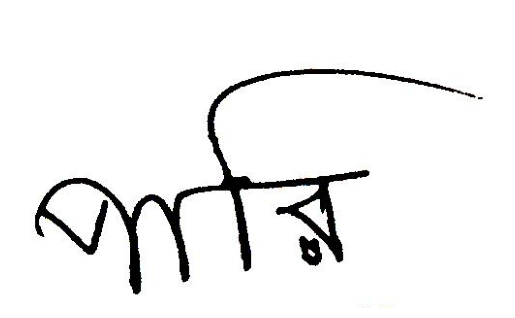

সেই


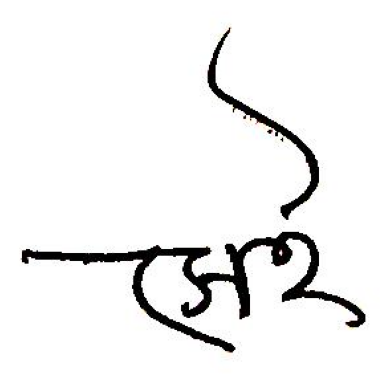

করে


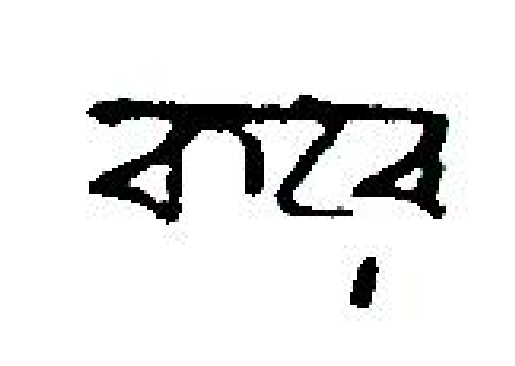

নেক


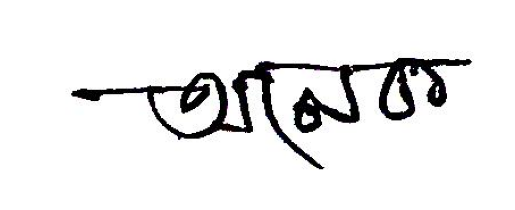

বছর


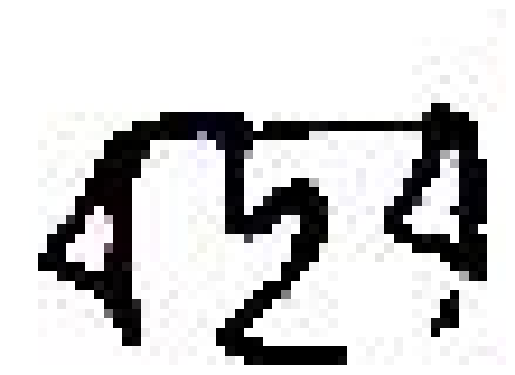

তা


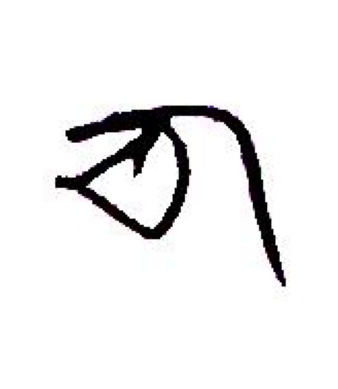

ুলের


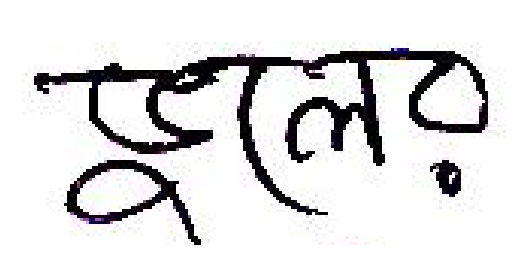

।


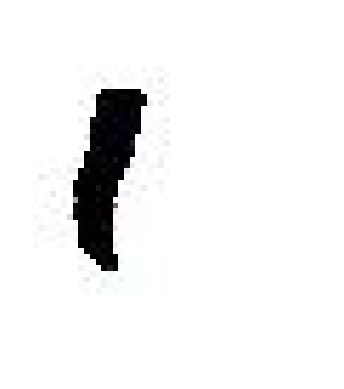

না


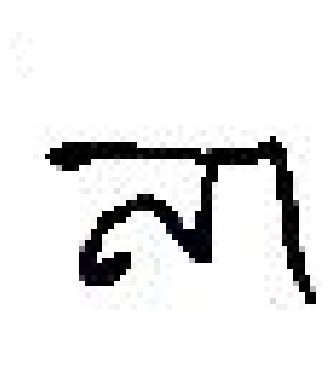

তিনি


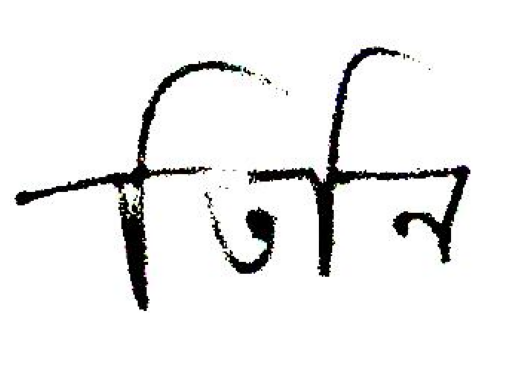

In [20]:
import random
import matplotlib.pyplot as plt

def process_image(image):
    device = next(model.parameters()).device
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_text

for i in range(10):
    idx = random.randint(0, len(valid_df) - 1)
    path = train_data.root_dir + '/' + valid_df['file'].iloc[idx]
    image = Image.open(path).convert("RGB")    
    # image.show()
    print(process_image(image))
    plt.imshow(image)
    plt.axis("off")  # Turn off axis for better visibility
    plt.show()

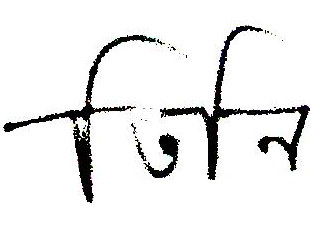

In [21]:
image = Image.open(path).convert("RGB")
image

In [22]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
from PIL import Image
 
# Load model and processor from the Hub
model = VisionEncoderDecoderModel.from_pretrained("Partha11/trocr-vit-model")
processor = TrOCRProcessor.from_pretrained("Partha11/trocr-vit-processor")
 
# Load Image and Process
image = Image.open("/kaggle/input/handwriting-dataset-v2/images/100_1_10_1.jpg").convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values
 
# Generate prediction
output_ids = model.generate(pixel_values)
predicted_text = processor.batch_decode(output_ids, skip_special_tokens=True)[0]
 
print(predicted_text)

config.json:   0%|          | 0.00/8.69k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

দেশুর
